# 09__mind_results
# running MIND on the deletion results

in this notebook, i run MIND on the deletion results. for more information on how MIND works, see **Fig S14** and the Github docs: https://github.com/kmattioli/mind

**NOTE: if you run this notebook with 10,000 shuffles for MIND (as I did in the paper) it is going to take over an hour to run (even more if you don't have access to 32 cores).**

------

figures in this notebook:
- **Fig 4E, top**: barplot of deletion effect sizes and sequence logo plotted proportionally to the loss scores of lncRNA DLEU1 promoter. all of these plots are made by the MIND algorithm and stored in the data/06__mind_results folder
- **Fig 4D**: heatmap showing all of the significant TFBSs predicted by MIND in HepG2

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
del_dir = "../../data/05__deletions"
mind_req_dir = "../../misc/06__mind_requirements"

In [4]:
# path to where MIND repo is stored
mind_path = "../../../mind"

In [5]:
# arguments required for MIND that already exist
pwm_file = "%s/pfm_vertebrates_meme_motifNameChanged.txt" % mind_req_dir
offset = 11
seq_len = 94
score_type = "loss"
cores = 32
n_shuffles = 10000

In [6]:
# file w/ tfs and their expression
tf_expr_f = "../../misc/03__rna_seq_expr/tf_tissue_sp.txt"

## 1. import deletion data and tf expr file

In [7]:
# hepg2
hepg2_files = []
for (dirpath, dirnames, filenames) in walk("%s/HepG2" % del_dir):
    hepg2_files.extend(filenames)
    break

In [8]:
# k562
k562_files = []
for (dirpath, dirnames, filenames) in walk("%s/K562" % del_dir):
    k562_files.extend(filenames)
    break

In [9]:
hepg2_data = {}
k562_data = {}
for files, data, cell in zip([hepg2_files, k562_files], [hepg2_data, k562_data], ["HepG2", "K562"]):
    data_dir = "%s/%s" % (del_dir, cell)
    for f in files:
        df = pd.read_table("%s/%s" % (data_dir, f))
        data[f] = df

In [10]:
# import tf expr data
tf_expr = pd.read_table(tf_expr_f, sep="\t")
tf_expr.head()

,motif_id,motif_name,ensembl_id,HeLa-S3,HepG2,K562,tissue_sp
0,MA0002.2,RUNX1,ENSG00000159216,1.859569,4.693606,9.631455,0.439869
1,MA0003.3,TFAP2A,ENSG00000137203,21.243269,0.000000,1.048992,0.650207
2,MA0007.3,Ar,ENSG00000169083,0.000000,0.000000,0.001697,0.666667
3,MA0009.2,T,ENSG00000164458,0.000000,0.000000,0.000000,NaN
4,MA0014.2,PAX5,ENSG00000196092,0.001618,0.000000,0.000000,0.666667


In [11]:
# filter to tfs that are expr in the 2 cell lines and write files
hepg2_tfs = tf_expr[tf_expr["HepG2"] > 1]["motif_name"]
k562_tfs = tf_expr[tf_expr["K562"] > 1]["motif_name"]

hepg2_tfs_f = "%s/hepg2_tfs.txt" % mind_req_dir
k562_tfs_f = "%s/k562_tfs.txt" % mind_req_dir

hepg2_tfs.to_csv(hepg2_tfs_f, sep="\t", header=False, index=False)
k562_tfs.to_csv(k562_tfs_f, sep="\t", header=False, index=False)

## 2. filter dfs to only those that are sig active (wt_class)

In [12]:
hepg2_data_filt = {}
k562_data_filt = {}
for data, data_filt in zip([hepg2_data, k562_data], [hepg2_data_filt, k562_data_filt]):
    for key in data:
        df = data[key]
        if df.wt_class.iloc[0] == "sig active":
            data_filt[key] = df

## 3. create deletion info files (required to run MIND)

In [13]:
hepg2_del_info_file = "%s/HepG2_del_info.txt" % mind_req_dir
k562_del_info_file = "%s/K562_del_info.txt" % mind_req_dir
for out_f, data_filt, cell in zip([hepg2_del_info_file, k562_del_info_file], [hepg2_data_filt, k562_data_filt],
                                  ["HepG2", "K562"]):
    data_dir = "%s/%s" % (del_dir, cell)
    with open(out_f, "w") as f:
        for key in data_filt:
            path = "%s/%s" % (data_dir, key)
            gene_name = key.split(".")[0]
            strand = key.split(".")[2]
            name = "%s__%s" % (gene_name, strand)
            line = "%s\t%s\n" % (path, name)
            f.write(line)
    f.close()

## 4. creat out dirs

In [14]:
out_dir = "../../data/06__mind_results"
!mkdir -p $out_dir
hepg2_out_dir = "%s/HepG2" % out_dir
k562_out_dir = "%s/K562" % out_dir
!mkdir -p $hepg2_out_dir
!mkdir -p $k562_out_dir

## 5. run algorithm

In [15]:
# hepg2
!python $mind_path/mind.py -p $pwm_file -d $hepg2_del_info_file -l $seq_len -t $score_type -c $cores -n $n_shuffles -e $hepg2_tfs_f -f $offset -o $hepg2_out_dir

plotting: enhancer_NEAT1__pX__tile2__minus
plotting: enhancer_MALAT1__pX__tile1__minus
plotting: enhancer_MALAT1__pX__tile2__minus
plotting: enhancer_TERC__pX__tile2__minus
plotting: enhancer_LINC_PINT__pX__tile1__minus
plotting: FALEC__p1__tile2__plus
plotting: GAS5__p1__tile1__minus
plotting: GAS5__p1__tile2__minus
plotting: ZBTB37__p1__tile1__plus
plotting: ZBTB37__p1__tile2__plus
plotting: LINC00467__p1__tile1__plus
plotting: LINC00467__p1__tile2__plus
plotting: NEAT1__p1__tile2__plus
plotting: MALAT1__p4__tile1__plus
plotting: MALAT1__p4__tile2__plus
plotting: MALAT1__p1__tile1__plus
plotting: HOTAIR__p1__tile2__minus
plotting: DLEU1__p1__tile1__plus
plotting: DLEU1__p1__tile2__plus
plotting: MEG3__p1__tile2__plus
plotting: CRNDE__p1__tile1__minus
plotting: CRNDE__p1__tile2__minus
plotting: FENDRR__p1__tile2__minus
plotting: FOXF1__p__tile1__plus
plotting: FOXF1__p__tile2__plus
plotting: ZFAS1__p1__tile1__plus
plotting: ZFAS1__p1__tile2__plus
plotting: TERC__p1__tile1__minus
plott

ONLY TFS EXPRESSED: found 6 motifs at 0.05 FDR
ZBTB37__p1__tile2__plus__peak2
ALL MOTIFS: found 0 motifs at 0.15 FDR
ONLY TFS EXPRESSED: found 0 motifs at 0.15 FDR
ZBTB37__p1__tile2__plus__peak3
ALL MOTIFS: found 40 motifs at 0.05 FDR
ONLY TFS EXPRESSED: found 40 motifs at 0.05 FDR
LINC00467__p1__tile1__plus__peak1
ALL MOTIFS: found 25 motifs at 0.05 FDR
ONLY TFS EXPRESSED: found 25 motifs at 0.05 FDR
LINC00467__p1__tile2__plus__peak1
ALL MOTIFS: found 1 motifs at 0.1 FDR
ONLY TFS EXPRESSED: found 1 motifs at 0.15 FDR
LINC00467__p1__tile2__plus__peak2
ALL MOTIFS: found 0 motifs at 0.15 FDR
ONLY TFS EXPRESSED: found 0 motifs at 0.15 FDR
LINC00467__p1__tile2__plus__peak3
ALL MOTIFS: found 0 motifs at 0.15 FDR
ONLY TFS EXPRESSED: found 0 motifs at 0.15 FDR
LINC00467__p1__tile2__plus__peak4
ALL MOTIFS: found 0 motifs at 0.15 FDR
ONLY TFS EXPRESSED: found 0 motifs at 0.1 FDR
LINC00467__p1__tile2__plus__peak5
ALL MOTIFS: found 13 motifs at 0.1 FDR
ONLY TFS EXPRESSED: found 13 motifs at 0.05 

In [16]:
# k562
!python $mind_path/mind.py -p $pwm_file -d $k562_del_info_file -l $seq_len -t $score_type -c $cores -n $n_shuffles -e $k562_tfs_f -f $offset -o $k562_out_dir

plotting: enhancer_MALAT1__pX__tile1__minus
plotting: enhancer_MALAT1__pX__tile2__minus
plotting: FALEC__p1__tile2__plus
plotting: GAS5__p1__tile1__minus
plotting: GAS5__p1__tile2__minus
plotting: ZBTB37__p1__tile2__plus
plotting: LINC00467__p1__tile1__plus
plotting: LINC00467__p1__tile2__plus
plotting: MALAT1__p1__tile2__plus
plotting: DLEU1__p1__tile1__plus
plotting: DLEU1__p1__tile2__plus
plotting: MEG3__p1__tile2__plus
plotting: FOXF1__p__tile2__plus
plotting: ZFAS1__p1__tile1__plus
plotting: ZFAS1__p1__tile2__plus
plotting: TERC__p1__tile1__minus
plotting: TERC__p1__tile2__minus
plotting: SAMMSON__p1__tile2__plus
plotting: LUCAT1__p1__tile2__minus
plotting: LINC_PINT__p2__tile1__minus
plotting: JPX__p1__tile1__plus
plotting: JPX__p1__tile2__plus
plotting: ANRIL__p1__tile1__minus

mapping motifs...
using multiprocessing
seq name: enhancer_MALAT1__pX__tile1__minus | n peaks: 1
seq name: enhancer_MALAT1__pX__tile2__minus | n peaks: 2
seq name: FALEC__p1__tile2__plus | n peaks: 1
seq 

## 6. make heatmap with TFs mapped in each sequence
note: use only HepG2 since there are more seqs expressed in HepG2 and use results filtered by TFs expr in HepG2

In [17]:
hepg2_files = []
for (dirpath, dirnames, filenames) in walk("%s/files/1__motif_scores" % hepg2_out_dir):
    hepg2_files.extend(filenames)
    break
hepg2_files = [x for x in hepg2_files if "expr_filt" in x]

In [18]:
hepg2_data = {}
for f in hepg2_files:
    df = pd.read_table("%s/files/1__motif_scores/%s" % (hepg2_out_dir, f))
    name = f.split(".")[0]
    hepg2_data[name] = df
list(hepg2_data.keys())[0:5]

['enhancer_NEAT1__pX__tile2__minus__peak1',
 'enhancer_NEAT1__pX__tile2__minus__peak2',
 'enhancer_MALAT1__pX__tile2__minus__peak1',
 'enhancer_MALAT1__pX__tile2__minus__peak2',
 'enhancer_MALAT1__pX__tile2__minus__peak3']

In [19]:
# first, put all gene data in dictionary of list of dataframes
hepg2_gene_data = {}
for peak in hepg2_data:
    peak_data = hepg2_data[peak]
    
    if "enhancer" not in peak:
        gene_name = peak.split("_")[0]
        prom_name = peak.split("_")[1]
        tile_name = peak.split("_")[2]
        strand_name = peak.split("_")[3]
    else:
        gene_name = peak.split("_")[0] + "_" + peak.split("_")[1]
        prom_name = peak.split("_")[2]
        tile_name = peak.split("_")[3]
        strand_name = peak.split("_")[4]
    peak_name = peak.split("__")[1]
    
    peak_data["gene_name"] = gene_name
    peak_data["prom_name"] = prom_name
    peak_data["tile_name"] = tile_name
    peak_data["strand_name"] = strand_name
    peak_data["peak_name"] = peak_name
    
    if "LINC" in gene_name:
        if "00467" not in gene_name:
            if "enhancer" in gene_name:
                gene_name = "enhancer_LINC-PINT"
            else:
                gene_name = "LINC-PINT"
    if gene_name not in hepg2_gene_data:
        hepg2_gene_data[gene_name] = [peak_data]
    else:
        current_gene_data = hepg2_gene_data[gene_name]
        current_gene_data.append(peak_data)

list(hepg2_gene_data.keys())[0:5]

['enhancer_NEAT1',
 'enhancer_MALAT1',
 'enhancer_TERC',
 'enhancer_LINC-PINT',
 'FALEC']

In [20]:
hepg2_sig_data = {}
hepg2_all_motifs = []
for gene in hepg2_gene_data:
    print(gene)
    dfs = hepg2_gene_data[gene]
    gene_motifs = []
    for df in dfs:
        sig_motifs = df[df["padj"] < 0.05]
        gene_motifs.extend(list(sig_motifs["motif"]))
    gene_motifs = list(set(gene_motifs))
    hepg2_all_motifs.extend(gene_motifs)
    if len(gene_motifs) == 0:
        continue
    hepg2_sig_data[gene] = gene_motifs

enhancer_NEAT1
enhancer_MALAT1
enhancer_TERC
enhancer_LINC-PINT
FALEC
GAS5
ZBTB37
LINC00467
NEAT1
MALAT1
HOTAIR
DLEU1
MEG3
FOXF1
ZFAS1
TERC
SAMMSON
LUCAT1
LINC-PINT
CDKN2A
ANRIL
JPX


In [21]:
hepg2_all_motifs = list(set(hepg2_all_motifs))
len(hepg2_all_motifs)

136

In [22]:
hepg2_motif_idx_dict = {k:v for k, v in zip(hepg2_all_motifs, list(range(0, len(hepg2_all_motifs))))}

In [23]:
hepg2_motif_array = np.zeros((len(hepg2_sig_data), len(hepg2_all_motifs)))
for i, gene in enumerate(hepg2_sig_data):
    motif_data = hepg2_sig_data[gene]
    motif_idxs = [hepg2_motif_idx_dict[motif] for motif in motif_data]
    #print(gene)
    for j in motif_idxs:
        hepg2_motif_array[i, j] = 1

hepg2_mo_df = pd.DataFrame(hepg2_motif_array, index=list(hepg2_sig_data.keys()), columns=hepg2_all_motifs)
hepg2_mo_df.head()

,JDP2,MAX,TEF,SP4,Gfi1,Stat6,HINFP,NR2F1,HLTF,SREBF2(var.2),...,Tcf7,TGIF1,RELA,SOX4,FOS,E2F6,ELF3,PPARG,ETV6,MYBL1
enhancer_NEAT1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
enhancer_TERC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
enhancer_LINC-PINT,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
FALEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAS5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
cmap = sns.light_palette("firebrick", reverse=False, as_cmap=True)

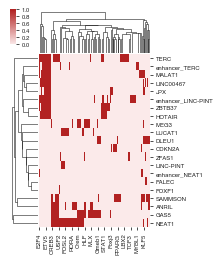

In [25]:
cg = sns.clustermap(hepg2_mo_df, annot=False, cmap=cmap, figsize=(2.5, 4))
cg.savefig("Fig_4D.pdf", bbox_inches="tight", dpi="figure")

## 7. plot number of motifs found in seqs expressed in only one cell type vs. two

### first load the k562 data

In [26]:
k562_files = []
for (dirpath, dirnames, filenames) in walk("%s/files/1__motif_scores" % k562_out_dir):
    k562_files.extend(filenames)
    break
k562_files = [x for x in k562_files if "expr_filt" in x]

In [27]:
k562_data = {}
for f in k562_files:
    df = pd.read_table("%s/files/1__motif_scores/%s" % (k562_out_dir, f))
    name = f.split(".")[0]
    k562_data[name] = df

### now compare

In [28]:
hepg2_peak_sig_data = {}
for tile in hepg2_data:
    df = hepg2_data[tile]
    fdr = df["fdr_cutoff"].iloc[0]
    sig_df = df[df["padj"] < fdr]
    sig_motifs = list(sig_df["motif"])
    hepg2_peak_sig_data[tile] = sig_motifs

In [29]:
k562_peak_sig_data = {}
for tile in k562_data:
    df = k562_data[tile]
    fdr = df["fdr_cutoff"].iloc[0]
    sig_df = df[df["padj"] < fdr]
    sig_motifs = list(sig_df["motif"])
    k562_peak_sig_data[tile] = sig_motifs

In [30]:
expr_in_hepg2_not_k562 = [x for x in hepg2_peak_sig_data.keys() if x not in k562_peak_sig_data.keys()]
expr_in_both = [x for x in hepg2_peak_sig_data.keys() if x in k562_peak_sig_data.keys()]

In [31]:
results_dict = {}
for gene in expr_in_hepg2_not_k562:
    sig_motifs = hepg2_peak_sig_data[gene]
    n_sig_motifs = len(sig_motifs)
    results_dict[gene] = (n_sig_motifs, "on in hepg2, not k562")
    
for gene in expr_in_both:
    hepg2_sig_motifs = hepg2_peak_sig_data[gene]
    k562_sig_motifs = k562_peak_sig_data[gene]
    all_motifs = hepg2_sig_motifs.extend(k562_sig_motifs)
    all_motifs = list(set(hepg2_sig_motifs))
    n_sig_motifs = len(all_motifs)
    results_dict[gene] = (n_sig_motifs, "on in both")

results_df = pd.DataFrame.from_dict(results_dict, orient="index").reset_index()
results_df.columns = ["gene", "n_sig_motifs", "type"]
results_df.head()

,gene,n_sig_motifs,type
0,enhancer_NEAT1__pX__tile2__minus__peak1,2,"on in hepg2, not k562"
1,enhancer_NEAT1__pX__tile2__minus__peak2,5,"on in hepg2, not k562"
2,enhancer_MALAT1__pX__tile2__minus__peak3,2,"on in hepg2, not k562"
3,enhancer_TERC__pX__tile2__minus__peak1,5,"on in hepg2, not k562"
4,enhancer_TERC__pX__tile2__minus__peak2,14,"on in hepg2, not k562"


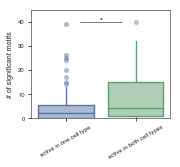

In [32]:
fig = plt.figure(figsize=(2.5, 2))
ax = sns.boxplot(data=results_df, x="type", y="n_sig_motifs", flierprops = dict(marker='o', markersize=5))
ax.set_xticklabels(["active in one cell type", "active in both cell types"], rotation=30)
mimic_r_boxplot(ax)
plt.xlabel("")
plt.ylabel("# of significant motifs")
plt.ylim((-0.1, 45))


# calc p-vals b/w dists
one_dist = np.asarray(results_df[results_df["type"] == "on in hepg2, not k562"]["n_sig_motifs"])
both_dist = np.asarray(results_df[results_df["type"] == "on in both"]["n_sig_motifs"])

one_dist = one_dist[~np.isnan(one_dist)]
both_dist = both_dist[~np.isnan(both_dist)]

u, pval = stats.mannwhitneyu(one_dist, both_dist, alternative="less", use_continuity=False)

# statistical annotation
annotate_pval(ax, 0.2, 0.8, 40, 0, 39, pval, fontsize)

fig.savefig("Fig_S15B.pdf", dpi="figure", bbox_inches="tight")

## 8. plot correlation b/w number of motifs found and ref tile activity

In [33]:
hepg2_del_info = pd.read_table(hepg2_del_info_file, sep="\t", header=None)
k562_del_info = pd.read_table(k562_del_info_file, sep="\t", header=None)
hepg2_del_info.columns = ["file", "name"]
k562_del_info.columns = ["file", "name"]
k562_del_info.head()

,file,name
0,../../data/05__deletions/K562/enhancer_MALAT1_...,enhancer_MALAT1__pX__tile1__minus
1,../../data/05__deletions/K562/enhancer_MALAT1_...,enhancer_MALAT1__pX__tile2__minus
2,../../data/05__deletions/K562/FALEC__p1__tile2...,FALEC__p1__tile2__plus
3,../../data/05__deletions/K562/GAS5__p1__tile1....,GAS5__p1__tile1__minus
4,../../data/05__deletions/K562/GAS5__p1__tile2....,GAS5__p1__tile2__minus


In [34]:
hepg2_del_info = {k:v for k,v in zip(list(hepg2_del_info["file"]), list(hepg2_del_info["name"]))}
k562_del_info = {k:v for k,v in zip(list(k562_del_info["file"]), list(k562_del_info["name"]))}

In [35]:
hepg2_dict = {}
k562_dict = {}
for file_map, data, d in zip([hepg2_del_info, k562_del_info], [hepg2_data, k562_data], [hepg2_dict, k562_dict]):
    for f in file_map:
        name = file_map[f]
        df = pd.read_table(f, sep="\t")
        wt_activ = df["wt_activ"].iloc[0]
        wt_class = df["wt_class"].iloc[0]
        
        # find num sig motifs
        n_tot_sig = 0
        peaks = [x for x in list(data.keys()) if name in x]
        for peak in peaks:
            m_df = data[peak]
            fdr = m_df["fdr_cutoff"].iloc[0]
            n_tot_sig += len(m_df[m_df["padj"] < fdr])
            
        d[name] = [wt_activ, wt_class, n_tot_sig]

In [36]:
hepg2_activ = pd.DataFrame.from_dict(hepg2_dict, orient="index").reset_index()
hepg2_activ.columns = ["seq_name", "activ", "class", "n_sig"]

k562_activ = pd.DataFrame.from_dict(k562_dict, orient="index").reset_index()
k562_activ.columns = ["seq_name", "activ", "class", "n_sig"]

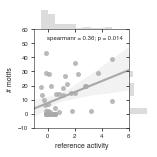

In [37]:
g = sns.jointplot(data=hepg2_activ, x="activ", y="n_sig", kind="reg", space=0, size=2.2, stat_func=spearmanr, 
                  marginal_kws={"hist": True, "kde": False, "bins": 10}, color="darkgrey", scatter_kws={"s": 25},
                  xlim=(-1, 6), ylim=(-10, 60))
g.set_axis_labels("reference activity", "# motifs")
g.savefig("Fig_S15A_1.pdf", dpi="figure", bbox_inches="tight")

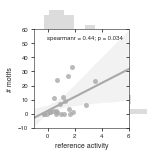

In [38]:
g = sns.jointplot(data=k562_activ, x="activ", y="n_sig", kind="reg", space=0, size=2.2, stat_func=spearmanr, 
                  marginal_kws={"hist": True, "kde": False, "bins": 10}, color="darkgrey", scatter_kws={"s": 25},
                  xlim=(-1, 6), ylim=(-10, 60))
g.set_axis_labels("reference activity", "# motifs")
g.savefig("Fig_S15A_2.pdf", dpi="figure", bbox_inches="tight")